<a href="https://colab.research.google.com/github/ankanghosh/multi-class-image-classification-with-a-convolutional-neural-network/blob/main/Multi_class_Image_Classification_Using_A_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The goal of this tutorial is to demonstrate training a simple Convolutional Neural Network (CNN) to classify images across multiple categories of vehicles and animals, such aeroplanes, automobiles,  birds, and cats, from the [CIFAR-10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset. The tutorial is based on TensorFlow's tutorials about [image classification](https://www.tensorflow.org/tutorials/images/classification) and [CNN](https://www.tensorflow.org/tutorials/images/cnn).

## Setup

Import the necessary libraries and the `datasets` module so we can import the [CIFAR-10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset.

In [ ]:
# Import the required libraries.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import drive

## Data and computing resources

To train the CNN in a time-efficient manner, we will use the TPUs or GPUs allotted under the free tier of Colab. However, if you do not enjoy usage restrictions, you could also consider [upgrading](https://colab.research.google.com/signup) to *Colab Pro* or go for *Pay As you Go*, as we will need to use a GPU or a TPU to process the data and to build the model.

We will be using a TPU in this work, as it is relatively cheaper than the GPUs available in the Colab environment. Additionally, TensorFlow is optimized for TPUs, allowing us to leverage its distributed computing capabilities to optimize the training time and resources and improve the training efficiency. To use a TPU, follow the steps below in the Colab environment.
*   Go to Runtime --> Change runtime type -->
Select v2-8 TPU under Hardware accelerator.

We can always monitor the usage of the resources we have selected as follows.
*   Go to Runtime --> View resources.

**Note:** A CPU would have worked fine in this case and would train in about 35 minutes. Feel free to use a CPU if time is not a constraint. Using a TPU can significantly reduce the time required to experiment with model architectures (more than 30 minutes in this case) or optimize training code, potentially saving several minutes in each iteration compared to using a CPU.

### Distributed training and parallelization

As indicated earlier, we would leverage TensorFlow's distributed computing framework to optimize the use of computational resources and to minimize the time and cost required to train our model. Go ahead and set up TensorFlow to leverage TPU resources for distributed training.

The `TPUClusterResolver` connects to the TPU system, initializes it, and verifies that the TPU resources are ready and properly configured before starting the training process.

In [ ]:
# Initialize the TPU cluster resolver to connect to the TPU system.
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()

# Connect to the TPU cluster using the resolver.
tf.config.experimental_connect_to_cluster(resolver)

# Initialize the TPU system to prepare it for training.
tf.tpu.experimental.initialize_tpu_system(resolver)

Define a strategy to distribute the training across TPU cores, aiming to accelerate and optimize the training process. It is worth noting that in this particular case, distributed computing using the `TPUStrategy` reduces the training time by a factor of tens, as compared to the time required to train the model without implementing parallelization.

In [ ]:
# Define the distribution strategy to distribute the training across the TPU cores.
strategy = tf.distribute.TPUStrategy(resolver)

## Prepare and explore the data

Load, prepare, inspect, and preprocess the data.

### Load and prepare the dataset

Import and load the [CIFAR-10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset directly from TensorFlow. The dataset consists of 60,000 color images across 10 categories or classes, with 6000 images per class, implying this is a multi-class classification problem. Each image has a resolution of `32x32 pixels`. Of these, 50,000 images are designated for training your model (a CNN in this case), and 10,000 images are reserved for testing and evaluating its classification accuracy - a measure of how accurately the model has learned to classify images.

In [ ]:
# Import the CIFAR-10 dataset from TensorFlow's "datasets" module.
cifar_10 = datasets.cifar10

# Load the CIFAR-10 dataset.
(train_images, train_labels), (test_images, test_labels) = cifar_10.load_data()

The dataset consists of the following four NumPy arrays.

* **`train_images` and `train_labels`:** The training data or the training set comprising the data that the model uses to learn.
* **`test_images` and `test_labels`:** The test data or the test set comprising the data used to test / evaluate the model.

Each image is a `32x32 pixel` NumPy array with 3 color channels `(R, G, B`), and the pixel values range from `0` to `255`. The labels are arrays of integers, with values ranging from `0` to `9`. Each of these values correspond to the class an image represents. Each image is mapped to a single label. See table below.

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Airplane</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Automobile</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Bird</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Cat</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Deer</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Dog</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Frog</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Horse</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Ship</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Truck</td>
  </tr>
</table>

**Note:** We will use the terms "class" and "label" interchangeably in this tutorial to refer to the categories of images in the dataset. A “label” specifically refers to the identifier assigned to a class.

Next, store the class names from the CIFAR-10 dataset for use later.

In [ ]:
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

### Inspect the data

Explore the shape of the training set and confirm there are 50,000 training images - each with dimensions of `32x32 pixels`.

In [ ]:
# Explore the shape of the training set.
train_images.shape

(50000, 32, 32, 3)

Confirm there are 50,000 labels in the training set.

In [ ]:
# Get the total number of labels in the training set.
len(train_labels)

50000

Investigate the labels in the training set.

In [ ]:
# Investigate the labels in the training set.
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

Notice that each label in the training set is a value between `0` and `9`. Next, explore the shape of the test set and confirm there are 10,000 test images. The dimensions of the test images would again be `32x32 pixels`.

In [ ]:
# Explore the shape of the test set.
test_images.shape

(10000, 32, 32, 3)

Confirm there are 10,000 labels in the test set.

In [ ]:
# Get the total number of labels in the test set.
len(test_labels)

10000

### Preprocess the data

The data needs to be preprocessed before training the model. This involves constructing a data pipeline to streamline the flow of data through stages, such as normalization (standardization), efficient data loading, and training optimization to help improve the performance of the data pipeline.

#### Configure the data for performance

Use `tf.data` to convert the training and test data into TensorFlow `Dataset` objects for efficient preprocessing and batching of the image data. Note that the data is required to be shuffled and packed into batches before being fed to the model / CNN.

In [ ]:
# Convert the training and test data into TensorFlow "Dataset" objects for efficient processing and batching.
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

There are two important methods that should be used when loading data to make sure that I/O does not become blocking.
1.   `cache()` keeps the images in the memory after they are loaded off the disk after the first epoch. This ensures that the dataset does not become a bottleneck while training the model. If the dataset is too large to fit into memory, this method can also be used to create a performant on-disk cache.
2.   `prefetch()` overlaps data preprocessing and model execution while training.

More on both of the aforementioned methods, as well as how to cache data to disk in the data performance guide [here](https://www.tensorflow.org/guide/data_performance).

The `shuffle()` method in the data pipeline randomizes the order of the elements in the dataset. This helps prevent overfitting of the data and improves the generalization capabilities of the model. `batch()` is responsible for grouping the data into batches.

Define the batch size and the buffer size for training the model.

In [ ]:
# Automatically tune the buffer size for optimal data loading performance.
AUTOTUNE = tf.data.AUTOTUNE

# Define the batch size.
BATCH_SIZE = 256

# Define the buffer size to shuffle the dataset.
BUFFER_SIZE = 1000

Next, go ahead and transform the training and test datasets for efficient training and evaluation. Use `shuffle()` and `batch()` to load the data and use training optimization techniques (`cache()` and `prefetch()`) to help improve the performance of the data pipeline.

In [ ]:
# Cache, shuffle, batch, and prefetch the training data to improve data pipeline performance.
train_dataset = (
    train_dataset
    .cache()  # Cache the training data in memory.
    .shuffle(BUFFER_SIZE)  # Shuffle the dataset to ensure the input data is randomized.
    .batch(BATCH_SIZE)  # Group data into "BATCH_SIZE" batches, discarding incomplete ones.
    .prefetch(buffer_size=AUTOTUNE)  # Use "tf.data.AUTOTUNE" for optimized prefetching.
)

# Cache, batch, and prefetch the test data to improve data pipeline performance.
test_dataset = (
    test_dataset
    .cache()  # Cache the test data in memory.
    .batch(BATCH_SIZE)  # Group data into "BATCH_SIZE" batches, discarding incomplete ones.
    .prefetch(AUTOTUNE)  # Use "tf.data.AUTOTUNE" for optimized prefetching.
)

Iterate over the training set and retrieve the shape of a single batch of images and labels.

In [ ]:
# Iterate over the training dataset and retrieve the shape of a single batch of images and labels.
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(256, 32, 32, 3)
(256, 1)


`image_batch` is a tensor of the shape `(256, 32, 32, 3)`, representing a batch of 256 images of shape `32x32x3 pixels` (the last dimension refers to the color channels `(R, G, B)`). `label_batch` is a tensor of the shape `(256, 1)` and represents the labels of the 256 images.

To verify that the data is in the correct format, visualize a few of the preprocessed images from the training set and the corresponding labels or class names.

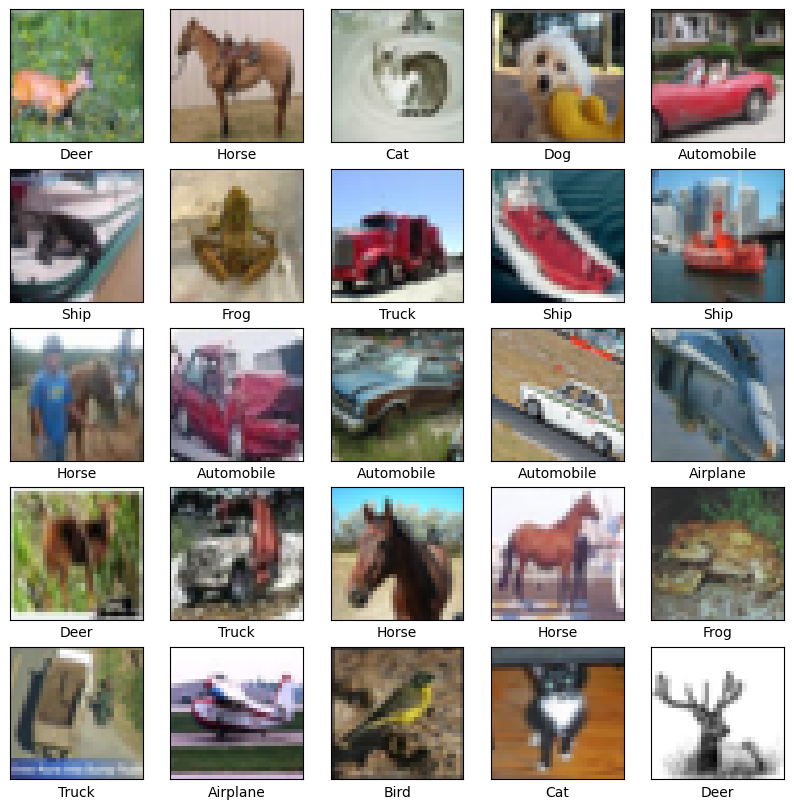

In [ ]:
# Set the size of the plot.
plt.figure(figsize=(10, 10))

# Iterate through one batch of images and labels from the training dataset.
for i, (image_batch, label_batch) in enumerate(train_dataset.take(1)):
    # Display 25 images.
    for j in range(25):
        # Create a grid of 5x5 subplots.
        plt.subplot(5, 5, j + 1)
        # Remove the x-axis ticks.
        plt.xticks([])
        # Remove the y-axis ticks.
        plt.yticks([])
        # Turn off the grid.
        plt.grid(False)

        # Extract a single image and its corresponding label from the batch.
        # Convert the image tensor to a NumPy array.
        image = image_batch[j].numpy()
        # Convert the label tensor to scalar value.
        label = label_batch[j].numpy().item()

        # Display the image in binary colormap (grayscale).
        plt.imshow(image, cmap=plt.cm.binary)
        # Set the label of the image.
        plt.xlabel(class_names[label])

# Display the plot.
plt.show()

#### Normalize the data

Inspect the pixel values of the first image from the training set. The values are in the range `0` to `255`.

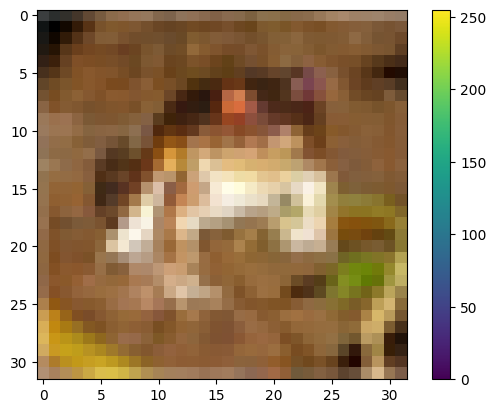

In [ ]:
# Inspect the pixel values of the first image from the training set.
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Define the normalization layer to scale the pixel values of the images in the dataset to be between `0` and `1`. We will use the `Rescaling` layer to normalize the images. The `Rescaling` layer is responsible for scaling the input pixel values by a specified factor (`255` in this case), ensuring consistent data preprocessing for models. Define a preprocessing function to normalize the images and retain the corresponding labels.

In [ ]:
# Define the normalization layer to scale the pixel values of the images in the dataset to be between "0" and "1".
normalization_layer = layers.Rescaling(1./255)

# Preprocessing function to normalize the images and retain the corresponding labels.
def preprocess_image(image, label):
    # Normalize the pixel values.
    image = normalization_layer(image)
    return image, label

Validate the normalization of the dataset by checking the pixel value range after applying the normalization layer. The `Rescaling` layer can be applied to the dataset by calling `tf.data.Dataset.map()`, or, you can include the layer inside the model definition to simplify deployment. We will use the second approach in this tutorial. However, let us review the first approach as well. Grab a single batch of images and labels from the normalized dataset and look at the range of pixel values of the first image in the batch.

In [ ]:
# Normalize the dataset and check the pixel values.
normalized_ds = train_dataset.map(preprocess_image)

# Get one batch of images and labels from the normalized dataset.
image_batch, labels_batch = next(iter(normalized_ds))

# Take the first image in the batch.
first_image = image_batch[0]

# Print the pixel value range of the first image after normalization.
print("Pixel value range after normalization:", np.min(first_image), np.max(first_image))

Pixel value range after normalization: 0.0 1.0


## Build and train the model

Build and train a model - specifically, a CNN, to perform multi-class classification of images using the preprocessed data.

### Define the convolutional base

A CNN is a type of deep learning model designed to process and classify visual data like images by automatically learning hierarchical features from input images. It consists of several key layers shown below.

1.   **Convolutional Layers:** These layers apply convolution operations to the input, using filters (kernels) to detect local patterns such as edges, textures, and simple shapes. Each filter slides over the input image, computing dot products to produce feature maps that highlight specific features.
2.   **Activation Function:** After convolution, the Rectified Linear Unit (ReLU) activation function is applied to the convolved feature map to introduce non-linearity into the model, enabling it to learn complex patterns. ReLU replaces negative pixel values in the feature map with zero, maintaining positive values unchanged.
2.   **Pooling Layers:** Pooling layers reduce the spatial dimensions of feature maps, retaining the most important information while decreasing computational load. Max pooling, for instance, selects the maximum value within a defined window, effectively downsampling the feature map.
2.   **Fully Connected (Dense) Layers:** In the final stages, fully connected layers interpret the high-level features extracted by previous layers to make predictions. These layers connect every neuron from the preceding layer to each neuron in the current layer, culminating in an output layer that provides classification probabilities across different categories.

By integrating the aforementioned layers, CNNs can effectively learn and recognize intricate patterns in images, making them highly proficient in tasks like image classification and object detection. For a more detailed explanation, refer to [this](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks) article about CNNs by Google.

Go ahead and define the convolutional base using the common pattern introduced earlier: a stack of convolutional (`tf.keras.layers.Conv2D`) and max pooling (`tf.keras.layers.MaxPooling2D`) layers. A CNN takes tensors of shape `(image_height, image_width, color_channels)` as input, ignoring the batch size. `color_channels` refers to the channel values `(R, G, B)`. The CNN needs to be configured according to the shape of the input CIFAR-10 images, which is `(32, 32, 3)`. This is achieved by passing the argument `input_shape` to the first layer in the model - the `Rescaling` layer used to normalize the images. To preserve spatial dimensions, use `same` padding, which adds zero-padding around the input so that the output feature map remains the same size as the input. This ensures that important edge features are not lost during convolution.

### Add dense layers

To perform classification, feed the last output tensor from the convolutional base into one or more `tf.keras.layers.Dense` layers. These are densely connected or fully connected neural layers that take One-Dimensional (1D) vectors as input, while the output of the convolutional base is a Three-Dimensional (3D) tensor. To solve for this, flatten (or unroll) the 3D output to a 1D vector using the `tf.keras.layers.Flatten` layer. This layer is responsible for unstacking the rows from the output of the convolutional base and flattening them into a single line of data. The `Flatten` layer has no parameters (weights and biases) to learn and is only responsible for reformatting the data.

Next, add a `Dense` layer on top of the `Flatten` layer. Finally, add a `Dense` layer with 10 output nodes / units / neurons. This final layer returns a logit array of length 10. Each logit corresponds to one of the 10 classes in the CIFAR-10 dataset and represents a raw, unnormalized score that indicates how likely the current image belongs to that class. Layers such as `Conv2D` and `Dense` have parameters that are learned from the input data during training, allowing the model to extract relevant features and make accurate predictions for classification.

**Note:** Instead of feeding the output of the convolutional base to the `Dense` layers directly, add a `tf.keras.layers.Dropout` layer in the middle to prevent overfitting. Dropout is used to regularize the model by randomly setting a fraction (20% here) of its input units to `0` during training to prevent overfitting.

### Build the model

Go ahead and build the model. To start with, define the image dimensions and the number of classes of images based on the dataset.

In [ ]:
# Height of an image in the dataset.
image_height = 32

# Width of an image in the dataset.
image_width = 32

# Number of classes of images in the dataset.
num_classes = len(class_names)

Go ahead and build the model. The model will utilize the distributed training infrastructure provided by the TPU. This requires initializing the model within the scope of the TPU’s distributed training strategy - `TPUStrategy`.

In [ ]:
# Build the model.
# Define the scope for distributed training using the specified strategy.
with strategy.scope():
    # Create a sequential model.
    model = models.Sequential([
        # Normalize pixel values to the range "[0, 1]" by rescaling them.
        layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),

        # Add a Two-Dimensional (2D) convolutional layer with 32 filters, a 3x3 kernel,
        # ReLU activation, and "same" padding to preserve the spatial dimensions.
        layers.Conv2D(32, (3, 3), padding="same", activation="relu"),

        # Add a max pooling layer with a 2x2 pool size to reduce the spatial dimensions.
        layers.MaxPooling2D((2, 2)),

        # Add a second 2D convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and "same" padding.
        layers.Conv2D(32, (3, 3), padding="same", activation="relu"),

        # Add another max pooling layer with a 2x2 pool size.
        layers.MaxPooling2D((2, 2)),

        # Add a third 2D convolutional layer with 64 filters, a 3x3 kernel, ReLU activation, and "same" padding.
        layers.Conv2D(64, (3, 3), padding="same", activation="relu"),

        # Add another max pooling layer with a 2x2 pool size.
        layers.MaxPooling2D((2, 2)),

        # Apply dropout to reduce overfitting by randomly setting a fraction of input units to "0".
        layers.Dropout(0.2),

        # Flatten the 2D feature maps into a 1D vector for the fully connected layers.
        layers.Flatten(),

        # Add a dense (fully connected) layer with 128 units and ReLU activation.
        layers.Dense(128, activation="relu"),

        # Add the output dense layer with "num_classes" units for multi-class classification.
        layers.Dense(num_classes)
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Investigate the model's architecture.

In [ ]:
# Investigate the model's architecture.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,130 (629.41 KB)

 Trainable params: 161,130 (629.41 KB)

 Non-trainable params: 0 (0.00 B)

Investigating the summary of the model confirms that the output of every `Conv2D` and `MaxPooling2D` layer is indeed a 3D tensor of shape `(image_height, image_width, color_channels)`. The height and width dimensions decrease as you go deeper into the network. The number of output channels for each `Conv2D` layer is controlled by the first argument (e.g., `32` or `64`). As the height and width decrease, it becomes computationally feasible to increase the number of output channels in deeper `Conv2D` layers. The network summary also reveals that the last output tensor from the convolutional base of shape `(4, 4, 64)` was flattened into a vector of shape `(1024)` before going through two `Dense` layers.

### Compile the model

There are a few more steps that need to be completed before training the model. They are added during the model's compile step.

* **Loss Function:** Quantifies how well the model’s predictions match the true labels during training. The objective is to minimize this value to steer the model in the right direction and improve its performance. For this tutorial, we will use the `tf.keras.losses.SparseCategoricalCrossentropy()` loss function.

* **Optimizer:** Determines how the model’s parameters are updated based on the loss function and the training data. Specifically, we will use the `adam` optimizer.

* **Metrics:** Used to monitor the performance of the model during training and testing steps. This work uses the metric `accuracy`. Accuracy refers to the fraction of the images that are correctly classified.

Compile the model with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric. Compiling the model needs to be done within the scope of the `TPUStrategy`.

In [ ]:
# Compile the model within the scope of the distributed training strategy using the Adam optimizer,
# sparse categorical crossentropy loss, and accuracy metric.
with strategy.scope():
    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

### Train the model

**Note:** In general, and as a best practice, datasets are divided into separate training, validation, and test sets. However, in this work, the test dataset is used for both validation (to validate the model during training) and testing (to evaluate the model’s performance). As a result, no separate validation dataset is defined.

Define an early stopping callback. This will help stop the training once the validation loss stops improving after a certain number of epochs.

In [ ]:
# Define an early stopping callback.
early_stopping = EarlyStopping(
    monitor="val_loss", # Monitor the validation loss.
    patience=3, # The number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the validation loss.
)

Train and fit the model.

In [ ]:
# Train and fit the model.
history = model.fit(
    train_dataset,          # Training data.
    epochs=50,             # Number of epochs (iterations over the entire dataset).
    validation_data=test_dataset,  # Validation data and labels.
    callbacks=[early_stopping],  # Early stopping callback.
    batch_size=BATCH_SIZE, # Number of samples per batch.
    verbose=1              # Level of verbosity during training (1: progress bar, 0: silent, 2: one line per epoch).
)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.2989 - loss: 1.9155 - val_accuracy: 0.4616 - val_loss: 1.5012
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5090 - loss: 1.3508 - val_accuracy: 0.5368 - val_loss: 1.2726
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5645 - loss: 1.2142 - val_accuracy: 0.5696 - val_loss: 1.2033
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6114 - loss: 1.0974 - val_accuracy: 0.6008 - val_loss: 1.1311
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6329 - loss: 1.0154 - val_accuracy: 0.6312 - val_loss: 1.0700
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6551 - loss: 0.9926 - val_accuracy: 0.6512 - val_loss: 0.9973
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6705 - loss: 0.9582 - val_accuracy: 0.6656 - val_loss: 0.9796
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6905 - loss: 0.8818 - val_acc

## Evaluate the model

After training, the model has learned to associate the images and the labels. In this section, we will perform the following tasks to evaluate the model.


*   Evaluate how the model performs with the test data.
*   Plot the loss and accuracy of the model with the training and validation data.
*   Have the model classify images from the test dataset.
*   Plot the confusion matrix to investigate how the model performs in terms of classifying images across classes.
*   Calculate the precision, recall, and F1 scores across classes.
*   Review how the model performs with unseen external data.

### Performance on test data

Evaluate the model and see how it performs on the test data in terms of the loss and accuracy.

In [ ]:
# Evaluate the model in terms of the loss and accuracy on the test data.
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

# Print the loss and accuracy on the test data.
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

40/40 - 1s - 26ms/step - accuracy: 0.7104 - loss: 0.8296
Test Loss: 0.8295773267745972
Test Accuracy: 0.7103999853134155


### Plot the training and validation loss and accuracy

Plot the accuracy and loss of the model for the training and validation data and investigate if we are overfitting or underfitting the data. The `history` object contains information about the training process that we will leverage.

In [ ]:
 # Extract the training history.
history_dict = history.history

# Explore the information about the training process available in the "history" object.
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
# Training accuracy.
acc = history_dict["accuracy"]

# Validation accuracy.
val_acc = history_dict["val_accuracy"]

# Training loss.
loss = history_dict["loss"]

# Validation loss.
val_loss = history_dict["val_loss"]

# Number of epochs used for training.
epochs = range(1, len(acc) + 1)

Plot the training and validation accuracy of the model.

In [ ]:
# Function to plot the training and validation accuracy of the model.
def plot_accuracy(history):
  # Plot the training & validation accuracy values.
  plt.figure(figsize=(12, 4))
  plt.plot(epochs, acc, label="accuracy")
  plt.plot(epochs, val_acc, label="val_accuracy")
  plt.title("Model Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(["Train", "Validation"], loc="upper left")
  plt.grid(True)
  plt.show()

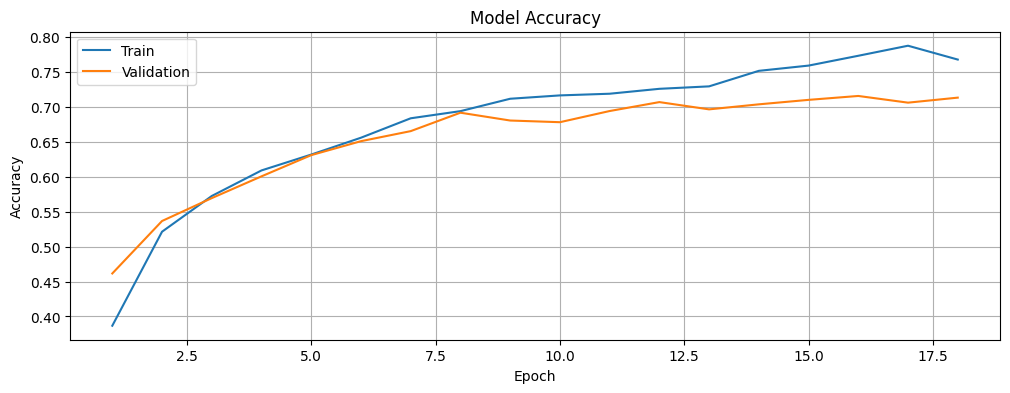

In [ ]:
# Plot the training and validation accuracy of the model.
plot_accuracy(history)

Plot the training and validation loss of the model.

In [ ]:
# Function to plot the training and validation loss of the model.
def plot_loss(history):
  # Plot the training & validation loss values.
  plt.figure(figsize=(12, 4))
  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Model Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(["Train", "Validation"], loc="upper left")
  plt.grid(True)
  plt.show()

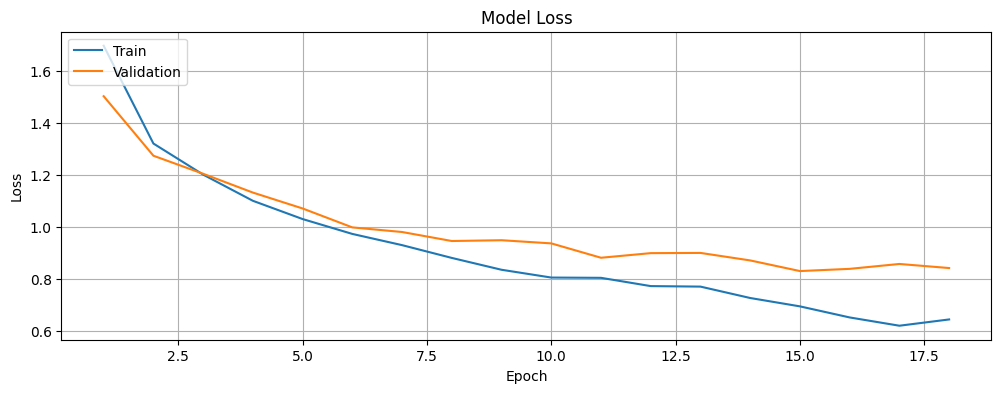

In [ ]:
# Plot the training and validation loss of the model.
plot_loss(history)

### Test the model

Use the trained model to make predictions (inference). Attach a softmax layer to the model’s linear, raw outputs (logits) to convert them into probabilities, making the predictions easier to interpret. The probability model should be initialized within the scope of the `TPUStrategy` to ensure efficient use of the distributed processing resources provided by the TPU.

In [ ]:
# Define the scope for distributed processing (inference) using the specified strategy.
with strategy.scope():
    # Convert the logits generated by the model to probabilities for easier interpretation.
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

Have the model predict the label for each image in the test set. The predicted (or classified) label will be the class with the highest probability among the 10 classes.

In [ ]:
# Have the mode predict the label for each image in the test set.
predictions = probability_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step


Review the prediction for the first image in the test set.

In [ ]:
# Review the prediction for the first image in the test set.
predictions[0]

array([1.4930260e-03, 2.5512979e-03, 6.6341710e-04, 8.3438051e-01,
       1.3784308e-04, 1.3721688e-01, 5.7808477e-03, 2.9984943e-04,
       1.7223541e-02, 2.5265603e-04], dtype=float32)

In this case, a prediction is an array of 10 values (see `predictions[0]`), each representing the model’s confidence that the image belongs to one of the 10 categories. The label with the highest confidence (probability) value represents the model’s prediction or classification. See which label has the highest confidence value.

In [ ]:
# See which label has the highest confidence (predicted probability) value for the first image.
np.argmax(predictions[0])

3

The 4th label (with index `3`) has the highest confidence value. This is aligned with the values in `predictions[0]`. This implies that the model is most confident that the first image is that of a cat, or `class_names[3]`. Examine the corresponding test label to confirm that this is the correct classification.

In [ ]:
# Print the test label for the first image.
test_labels[0][0]

3

Define functions to plot the full set of predictions for the 10 classes. Start by defining a function to plot a test image along with its predicted and true labels.

In [ ]:
# Function to plot an image along with its predicted and true labels.
def plot_image(i, predictions_array, true_label, img):
    # Extract the true label and the corresponding image.
    true_label, img = true_label[i][0], img[i]

    # Remove the grid and the x- and y-axis ticks for a cleaner display.
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Display the image.
    plt.imshow(img)

    # Determine the predicted label.
    predicted_label = np.argmax(predictions_array)

    # Set the color of the label based on the correctness of the prediction.
    color = "blue" if predicted_label == true_label else "red"

    # Add the label with the predicted class, its confidence value, and the true class to the image.                                    color=color)
    plt.xlabel(
        f"{class_names[predicted_label]} {100*np.max(predictions_array):.0f}%\n({class_names[true_label]})",
        color=color,
        fontsize=8
    )

Define another function to plot a bar chart of class probabilities, highlighting the predicted and true labels.

In [ ]:
# Function to plot a bar chart of class probabilities, highlighting the predicted and true labels.
def plot_value_array(i, predictions_array, true_label):
    # Extract the true label for the given index.
    true_label = true_label[i][0]

    # Disable grid lines for a cleaner plot.
    plt.grid(False)

    # Define the x-axis positions for the 10 class labels.
    positions = np.arange(10)

    # Set the x-axis labels with 90° rotation and center alignment.
    plt.xticks(positions,
              class_names,
              rotation=90,
              ha="right",
              va="center",
              rotation_mode="anchor",
              fontsize=8)

    # Remove the y-axis tick marks for a simpler appearance.
    plt.yticks([])

    # Plot a bar chart of class probabilities with a default gray color for the bars.
    bar = plt.bar(positions, predictions_array, color="#777777", width=0.8, align="center")

    # Set y-axis limits to ensure the probabilities stay within the range "[0, 1]".
    plt.ylim([0, 1])

    # Identify the predicted label (class with the highest probability).
    predicted_label = np.argmax(predictions_array)

    # Highlight the predicted label in red and the true label in blue.
    bar[predicted_label].set_color("red")
    bar[true_label].set_color("blue")

Make a few predictions. Plot and examine the image, prediction, and prediction array. Check the prediction at index `0` (first image in the test set) in the predictions array. The correct prediction labels are `blue` and incorrect prediction labels are `red`. The number represents the model’s confidence (predicted probability) for the predicted label, expressed as a percentage. In this case, the model is `83%` confident that the image is that of a cat, which is the correct prediction.

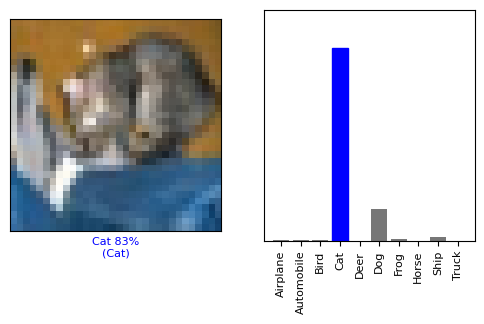

In [ ]:
# Display a single test image along with its predicted label, confidence values for each class, and the true label.
# Color correct predictions in blue and incorrect predictions in red.
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Check the prediction at index `12` (thirteenth image in the test set) in the predictions array. The model predicts that there is a `48%` chance that the image is that of a dog, which is the correct prediction.

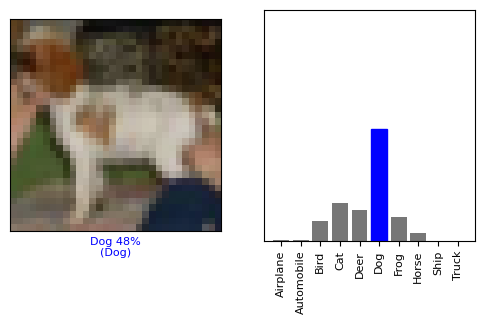

In [ ]:
# Display a single test image along with its predicted label, confidence values for each class, and the true label.
# Color correct predictions in blue and incorrect predictions in red.
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Next, plot several images along with their predictions. Start by setting up the grid layout for visualization. Note that the model can still be wrong, even with a high degree of confidence.

In [ ]:
# Set up the grid layout for visualization.
# Define the number of rows and columns.
num_rows, num_cols = 5, 3

# Calculate the total number of images to display.
num_images = num_rows * num_cols

Visualize the predictions made by the model by displaying some of the images alongside their predicted labels and class probability distributions. Also, adjust the subplot spacing for better visibility.

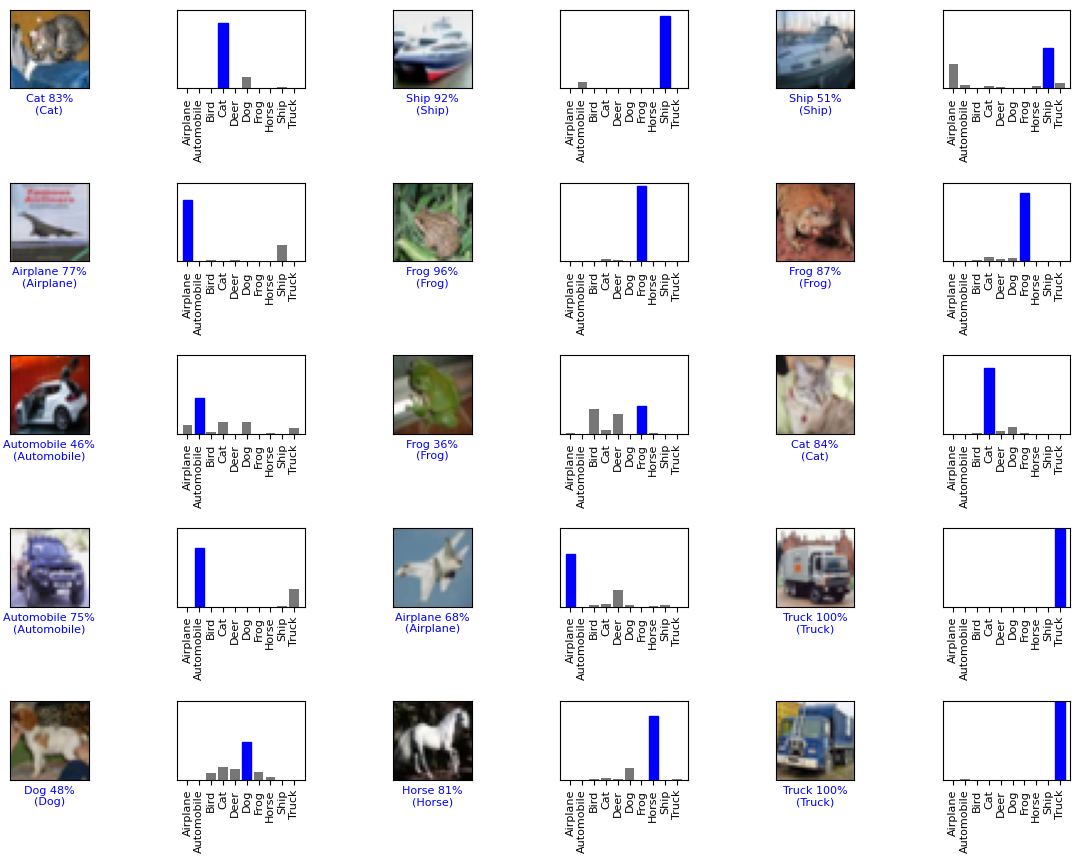

In [ ]:
# Create a new figure.
plt.figure(figsize=(14, 10))

# Loop through the specified number of images.
for i in range(num_images):
    # Plot the image along with its predicted and true labels.
    plt.subplot(num_rows, num_cols * 2, 2 * i + 1)
    plot_image(i, predictions[i], test_labels, test_images)

    # Plot the corresponding bar chart of class probabilities.
    plt.subplot(num_rows, num_cols * 2, 2 * i + 2)
    plot_value_array(i, predictions[i], test_labels)

# Adjust the subplot spacing for better visibility.
plt.subplots_adjust(wspace=0.5, hspace=1.2)

plt.show()

### Confusion matrix

Plot the confusion matrix to investigate how the model performs in terms of classifying images across classes, including false positives and false negatives. To do that, convert the test predictions, which are probabilities, into predicted class labels by selecting the class with the highest probability for each image.

In [ ]:
# Convert predictions to class labels by selecting the class with the highest probability.
predicted_labels = np.argmax(predictions, axis=1)

# Confusion matrix.
cm = confusion_matrix(test_labels, predicted_labels)

Plot the confusion matrix based on the labels in the test set and the labels predicted by the model.

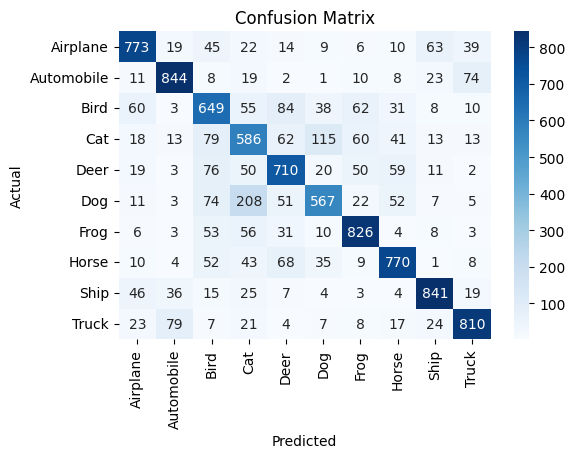

In [ ]:
# Plot the confusion matrix.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Precision, recall, and F1 score

For additional insights, calculate the True Positives (TPs), False Positives (FPs), and False Negatives (FNs) for each class, and use them to calculate the `precision`, `recall`, and `F1 score` for each class. More on these metrics below and in [this](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall) article from TensorFlow.

*   **Precision:** Proportion of correctly predicted positive instances out of all predicted positives.
*   **Recall:** Proportion of correctly predicted positive instances out of all actual positives.
*   **F1 Score:** Harmonic mean of precision and recall, balancing both metrics.

In [ ]:
# TPs for each class are the diagonal elements.
TP = np.diagonal(cm)

# FPs for each class: Sum of each column - "TP"
FP = cm.sum(axis=0) - TP

# FNs for each class: Sum of each row - "TP"
FN = cm.sum(axis=1) - TP

# Precision for each class.
precision = TP / (TP + FP)
# Handle division by zero.
precision = np.nan_to_num(precision)

# Recall for each class.
recall = TP / (TP + FN)
# Handle division by zero.
recall = np.nan_to_num(recall)

# F1 score for each class.
F1_score = 2 * (precision * recall) / (precision + recall)
# Handle division by zero.
F1_score = np.nan_to_num(F1_score)

# Print the precision, recall, and F1 score for each class.
print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("F1 score for each class:", F1_score)

Precision for each class: [0.79119754 0.83813307 0.61342155 0.54009217 0.68731849 0.70347395
 0.78219697 0.77309237 0.84184184 0.82400814]
Recall for each class: [0.773 0.844 0.649 0.586 0.71  0.567 0.826 0.77  0.841 0.81 ]
F1 score for each class: [0.78199292 0.8410563  0.63070943 0.56211031 0.69847516 0.62790698
 0.80350195 0.77154309 0.84142071 0.81694402]


### Predict on new data

Use the trained model to classify a test image - an unseen external image of your choice that was not included in the training and test datasets, and see how it performs. Upload the test image to Google Drive and define the path to import the image. For the test image, we have already saved an image of a bird on Google Drive.

In [ ]:
# Import the dataset from Google Drive.
drive.mount("/content/drive")

# Define the file path for the test image.
test_image_path = "/content/drive/MyDrive/Data/Images/Image_Classification_Using_CNN_With_CIFAR-10/test_image_bird.jpg"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load, resize, and display the test image and its shape before converting it for the model input. Resizing is required to ensure the image has a shape of `32x32 pixels`, something the model expects.

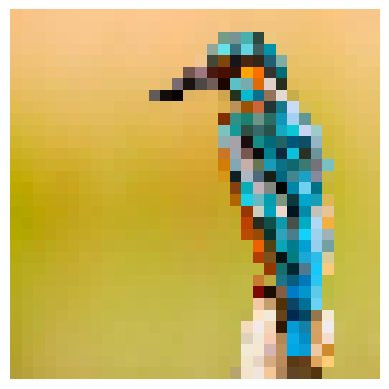

In [ ]:
# Load the test image and resize it to match the model's expected input shape.
img = tf.keras.utils.load_img(
    test_image_path, target_size=(image_height, image_width)
)

# Display the test image to verify the input.
plt.imshow(img)

# Hide the axis for a cleaner visualization.
plt.axis("off")
plt.show()

Convert the test image to a TensorFlow tensor and print its shape to confirm.

In [ ]:
# Convert the image to a TensorFlow tensor.
test_image_array = tf.keras.utils.img_to_array(img)

# Print the shape of the test image.
print(test_image_array.shape)

(32, 32, 3)


`tf.keras` models are optimized to make batch predictions on collections of examples. Therefore, even a single image is required to be wrapped in a list. Add the selected test image to a batch where it is the only member and print its new shape.

In [ ]:
# Expand the dimensions to create a batch, as the model expects input in batches.
test_image_array = tf.expand_dims(test_image_array, 0)

# Print the shape of the image.
print(test_image_array.shape)

(1, 32, 32, 3)


Next, predict the label for the test image - the most likely class, along with a confidence score, and print the same. In this case, the model is `96.59%` confident that the image is that of a bird, which is the correct prediction.

In [ ]:
# Make a prediction using the trained model.
predictions_test = model.predict(test_image_array)

# Print the predicted label for the image.
print(predictions_test)

# Apply softmax to get the probability score.
score = tf.nn.softmax(predictions_test[0])

# Print the predicted class along with the confidence score.
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[ 2.1788614 -1.0816616  6.6430807  0.6413173 -2.0636094 -1.3246173
   2.2501059  1.7336057 -2.4221075 -1.0553437]]
This image most likely belongs to Bird with a 96.59 percent confidence.


`tf.keras.Model.predict()` returns a list of lists (a batch of predictions), where each inner list corresponds to the class probabilities for an image in the batch. You can manually extract and review the prediction for our single image in the batch by accessing the first element of the output.

In [ ]:
# Get the index of the class with the highest predicted probability from the model's output.
np.argmax(predictions_test[0])

2

## Thoughts

The goal of this tutorial was to demonstrate training a basic CNN to classify images in the CIFAR-10 dataset. Our CNN / model achieves a reasonable performance with an accuracy of about 71%. The model is able to correctly classify an external image of a bird with a confidence of `96.59%`. It is important to note that this is a quick and dirty implementation of a very simple CNN, and the results are not too bad based on the same.

It is also worth noting that while the training and validation loss decrease with time, the accuracy increases before stabilizing. At this stage, there is a small gap between the training and validation accuracy (around 5%), which suggests that the model is generalizing well to unseen data. While there may be slight overfitting, it is not severe enough to impact the model’s ability to classify new images accurately. This balance indicates that the model is neither underfitting nor is it excessively tied to the training data.

The confusion matrix reveals interesting insights. The model seems to confuse different types of vehicles, such as airplanes, automobiles, ships, and trucks, as well as animals like birds, cats, deers, dogs, frogs, and horses. This behavior is more prominent in pairs like automobiles and trucks and cats and dogs. Another interesting observation is that the model tends to confuse airplanes with birds and vice versa, due to the similarity in their shapes. The precision, recall, and F1 scores indicate moderate performance. There is noticeable variability for the classes `Bird`, `Cat`, `Deer`, and `Dog`, where the precision, recall, and F1 score are comparatively lower, consistent with the patterns observed in the confusion matrix.

## Next steps

Of course, there is a definite scope for improvement in this work. There are multiple ways to further develop this dirty implementation and improve the model's performance / accuracy for the multi-class classification of images. Some of those are listed below.



1.   **Modifying the Architecture:** Experiment with deeper CNNs by adding more convolutional layers, pooling layers, or fully connected layers. Introduce advanced architectures like ResNet, Inception, or MobileNet for better feature extraction.
2.   **Hyperparameter Tuning:** Optimize learning rates, batch sizes, the number of epochs, kernel sizes, and strides.
3.   **Regularization:** Use L2 regularization to reduce overfitting by applying weight penalties during training. Other techniques that can be used to prevent overfitting include using learning rate warmup, learning rate schedulers, and advanced techniques like label smoothing.
4.   **Data Augmentation:** Apply image-specific augmentation techniques like rotation, flipping, scaling, cropping, brightness adjustment, and random noise addition. Use libraries, such as [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), [Albumentations](https://albumentations.ai/), or [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html) to implement augmentation pipelines. Also, refer to TensorFlow's [tutorial](https://www.tensorflow.org/tutorials/images/classification) on image classification for data augmentation.
5.   **Ensemble Methods:** Use ensemble methods like combining predictions from multiple models to improve performance. Use techniques, such as weighted averaging, majority voting, or stacking for ensembling.
6.   **Transfer Learning with Pre-trained Models:** Fine-tune pre-trained models like [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16), [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50), or [EfficientNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) for the dataset. Freeze lower layers and train only the top layers initially, then gradually unfreeze more layers for fine-tuning.
7.  **Fine-tuning Pre-trained Vision Transformers (ViTs):** Explore ViTs or hybrid models combining CNNs with attention mechanisms for improved performance.
8.   **Hyperparameter Optimization:** Use libraries, such as [Keras Tuner](https://keras.io/keras_tuner/) or [Optuna](https://optuna.org/) to find the best hyperparameters for the model.
9.   **Monitoring and Analysis:** Visualize feature maps from convolutional layers to understand what the model is learning. Use tools like TensorBoard or Weights & Biases for detailed training analysis.
10.  **Optimizing for Edge Devices:** Use [LiteRT](https://ai.google.dev/edge/litert) (short for Lite Runtime), formerly known as TensorFlow Lite - a set of tools facilitating on-device machine learning by helping developers run their models on mobile, embedded, and edge devices, based on TensorFlow's [tutorial](https://www.tensorflow.org/tutorials/images/classification) on image classification.